# 액티브 러닝을 하기 위한 구문
#### 베이스 라인부터 시작해서 학습 후 액티브 러닝, k-mean을 이용하여 추출한 총 300개 정도의 데이터에 수동으로 라벨링한 후 다시 베이스 + 수동 라벨 1.... 학습 + 액티브 러닝 반복하는 식 / 추가로 이미 뽑힌 것은 다시 뽑히지 않도록 방지하는 로직 추가
모델은 TF-IDF + logistic regression을 사용하여 학습하였다.
이를 통해 의미있는 라벨을 가진 데이터를 충분히 모은 뒤 이후 BERT 모델을 사용하여 학습을 진행한다.

In [13]:
# !python baseline_model.py # TF-IDF + logistic regression을 통해 인풋 데이터 comments_labeled + manual_labeled_round*.csv 학습

# import os
# import glob
# import pandas as pd
# from sentiment_utils import select_active_learning_candidates

# CSV_POOL = 'comments_unlabeled.csv'    # 전체 unlabeled 풀
# ART_DIR  = 'artifacts/classic'         # 최신 학습된 모델 디렉토리

# # 1) 지금까지 라벨링된 텍스트 모으기
# labeled_texts = set()

# # base labeled (weak + 이전 merged 등)
# for base_path in ['comments_labeled.csv', 'comments_labeled_merged.csv']:
#     if os.path.exists(base_path):
#         df_base = pd.read_csv(base_path, encoding='utf-8', dtype=str)
#         text_col = 'text' if 'text' in df_base.columns else df_base.columns[0]
#         labeled_texts.update(df_base[text_col].astype(str).tolist())

# # manual_labeled_round*.csv 들 전부 포함
# for p in glob.glob('manual_labeled_round*.csv'):
#     df_m = pd.read_csv(p, encoding='utf-8', dtype=str)
#     text_col = 'text' if 'text' in df_m.columns else df_m.columns[0]
#     labeled_texts.update(df_m[text_col].astype(str).tolist())

# print("지금까지 라벨된 텍스트 개수:", len(labeled_texts))

# # 2) unlabeled 풀에서 이미 본 텍스트 제거
# df_pool = pd.read_csv(CSV_POOL, encoding='utf-8', dtype=str)
# pool_text_col = 'text' if 'text' in df_pool.columns else df_pool.columns[0]
# mask_new = ~df_pool[pool_text_col].astype(str).isin(labeled_texts)
# df_pool_filtered = df_pool[mask_new].reset_index(drop=True)

# print("필터링 전 풀 크기:", len(df_pool))
# print("필터링 후 풀 크기:", len(df_pool_filtered))

# # 필요하면 임시로 저장해두고
# df_pool_filtered.to_csv('comments_unlabeled_filtered.csv', index=False, encoding='utf-8-sig')

# # 3) 필터링된 풀에 대해 Active Learning 후보 뽑기
# df_cand = select_active_learning_candidates(
#     csv_path='comments_unlabeled_filtered.csv',
#     art_dir=ART_DIR,
#     K=65,            # 후보 대략 개수 상한
#     per_cluster=5,   # 클러스터당 몇 개
#     tau_for_low=0.6, # p_max < 0.6 인 애들만
# )

# print("이번 라운드 후보 개수:", len(df_cand))
# df_cand.to_csv('al_round_candidates.csv', index=False, encoding='utf-8-sig')


In [14]:
# from sentiment_utils import batch_predict

# # 이미 artifacts/classic 에 model, vectorizer들이 저장되어 있다고 가정
# batch_predict(
#     csv_path='comments_new.csv',  # 실제 댓글 CSV
#     art_dir='artifacts/classic',
#     out_path='my_new_with_pred.csv',
#     tau=0.42,
#     gap=0.02,
# )

In [15]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # === 1) Load predicted CSV ===
# CSV_PATH = "my_new_with_pred.csv"   # batch_predict에서 out_path로 지정한 파일
# df = pd.read_csv(CSV_PATH, encoding="utf-8")

# # 안전한 text 컬럼 결정
# TEXT_COL = "text_clean" if "text_clean" in df.columns else ("text" if "text" in df.columns else df.columns[0])

# # 클래스 순서 고정
# LABELS = ["neg", "neu", "pos"]



# # === 3) Representative examples per label (top-k by class probability) ===
# def top_examples(ddf: pd.DataFrame, label: str, k: int = 20):
#     pcol = f"p_{label}" if f"p_{label}" in ddf.columns else None
#     sub = ddf[ddf["pred"] == label].copy()
#     if len(sub) == 0:
#         return pd.DataFrame(columns=[TEXT_COL, pcol] if pcol else [TEXT_COL])

#     if pcol:
#         sub = sub.sort_values(pcol, ascending=False)
#         cols = [TEXT_COL, pcol]
#     else:
#         # fallback: 정렬 기준이 없으면 전체 확률 max로 근사
#         prob_cols = [c for c in ddf.columns if c.startswith("p_")]
#         if prob_cols:
#             sub["p_max"] = sub[prob_cols].max(axis=1)
#             sub = sub.sort_values("p_max", ascending=False)
#             cols = [TEXT_COL, "p_max"]
#         else:
#             cols = [TEXT_COL]

#     return sub[cols].head(k)

# label_counts =  df["pred"].value_counts()
# labels = label_counts.index.tolist()
# counts = label_counts.values.tolist()

# plt.figure(figsize=(6, 4))
# plt.bar(labels, counts)
# plt.title("Prediction Label Distribution")
# plt.xlabel("Label")
# plt.ylabel("Count")
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

# for lab in LABELS:
#     print(f"\n===== Top {lab} examples (k=5) =====")
#     disp = top_examples(df, lab, k=30)
#     # 보기 좋게 출력
#     if disp.empty:
#         print("(no examples)")
#     else:
#         for i, row in disp.iterrows():
#             score = None
#             if f"p_{lab}" in disp.columns:
#                 score = row[f"p_{lab}"]
#             elif "p_max" in disp.columns:
#                 score = row["p_max"]
#             text = str(row[TEXT_COL]).strip().replace("\n", " ")
#             if score is not None:
#                 print(f"- [{score:.3f}] {text}")
#             else:
#                 print(f"- {text}")


#주 모델 BERT (학습 데이터가 ./bert_sentiment에 존재할 경우 학습용 데이터를 가지고 마지막 셀만 실행하면됨.)
active learning 이후 정제된 데이터를 얻은 후 pre-trained된 bert모델을 사용하여 라벨이 붙어있는 데이터를 학습시켜 추론을 진행하도록 한다.



In [16]:
!pip install -U "transformers[torch]" datasets accelerate
!pip install -q transformers datasets accelerate scikit-learn


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 인풋 데이터 경로
MERGED_CSV = "comments_labeled_for_training.csv"

df = pd.read_csv(MERGED_CSV)

text_col = "text" #댓글 내용
label_col = "label" #댓글 내용에 대한 반응 라벨

label2id = {"neg": 0, "neu": 1, "pos": 2}
id2label = {v: k for k, v in label2id.items()}


df = df[df[label_col].isin(label2id.keys())].copy()
df["label_id"] = df[label_col].map(label2id)

print(df[label_col].value_counts())

train_df, valid_df = train_test_split( #학습용  train, valid비율 나눠서
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label_id"],
)

len(train_df), len(valid_df)


label
neu    9063
pos    5269
neg    3967
Name: count, dtype: int64


(14639, 3660)

In [18]:
from transformers import AutoTokenizer
from datasets import Dataset

model_name = "xlm-roberta-base" #영어, 한국어가 강하게 pre-trained된 bert 모델을 사용

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(examples):
    texts = [str(x) if x is not None else "" for x in examples[text_col]]
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,
    )

# HF Dataset으로 변환
train_ds = Dataset.from_pandas(train_df[[text_col, "label_id"]])
valid_ds = Dataset.from_pandas(valid_df[[text_col, "label_id"]])

# 토크나이징
train_ds = train_ds.map(tokenize_fn, batched=True)
valid_ds = valid_ds.map(tokenize_fn, batched=True)

# label_id → labels
train_ds = train_ds.rename_column("label_id", "labels")
valid_ds = valid_ds.rename_column("label_id", "labels")

# index 컬럼 제거
cols_to_remove = [c for c in train_ds.column_names if c not in ["input_ids", "attention_mask", "labels", text_col]]
train_ds = train_ds.remove_columns([c for c in cols_to_remove if c != text_col])
valid_ds = valid_ds.remove_columns([c for c in cols_to_remove if c != text_col])

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
valid_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/14639 [00:00<?, ? examples/s]

Map:   0%|          | 0/3660 [00:00<?, ? examples/s]

In [19]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": macro_f1}


training_args = TrainingArguments(
    output_dir="./bert_sentiment",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("./bert_sentiment")
tokenizer.save_pretrained("./bert_sentiment")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,1.051800
100,0.963600
150,0.873300
200,0.795000
250,0.793500
300,0.769500
350,0.794400
400,0.713800
450,0.676700
500,0.652000


('./bert_sentiment/tokenizer_config.json',
 './bert_sentiment/special_tokens_map.json',
 './bert_sentiment/sentencepiece.bpe.model',
 './bert_sentiment/added_tokens.json',
 './bert_sentiment/tokenizer.json')

In [20]:
eval_res = trainer.evaluate()
print(eval_res)

# classification_report
preds = trainer.predict(valid_ds)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=-1)

print(classification_report(
    y_true,
    y_pred,
    target_names=["neg", "neu", "pos"],
    digits=4,
))


{'eval_loss': 0.4762616455554962, 'eval_accuracy': 0.8213114754098361, 'eval_macro_f1': 0.8053995382097877, 'eval_runtime': 21.3811, 'eval_samples_per_second': 171.179, 'eval_steps_per_second': 5.379, 'epoch': 3.0}
              precision    recall  f1-score   support

         neg     0.7518    0.6721    0.7097       793
         neu     0.8281    0.8555    0.8416      1813
         pos     0.8553    0.8748    0.8649      1054

    accuracy                         0.8213      3660
   macro avg     0.8117    0.8008    0.8054      3660
weighted avg     0.8194    0.8213    0.8197      3660



The tokenizer you are loading from './bert_sentiment' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Saved → comments_new_with_bert_pred.csv


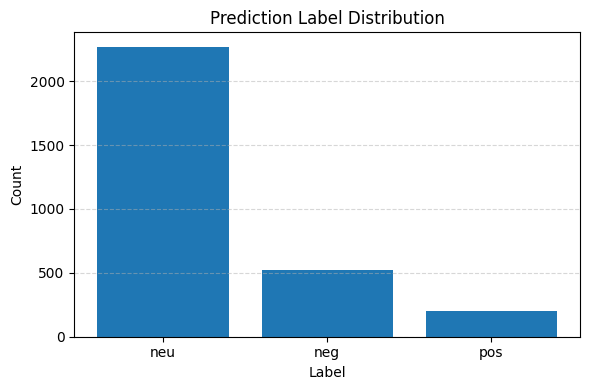


대표 문장 20개 — label: neu
01. 02:21 "커피 주문하러 왔는데, 갑자기 말을 거니까..." Z세대 당사자에게 직접 물어봄
02. 대답을 버벅일 순 있음  근데 뻔히 쳐다보는 건 그냥 정신질환인듯
03. 혼돈의 카오스
04. 아.....sns........
05. 코로나까지 거치면서 심각해진거네. 오프라인 세대는 무조건해야하는 대인 대면 행위를 많이 경험하면, 상투적인 반응이 자동으로 나올 듯.
06. 이런 친구가 많긴 하드라. 일단 이라도 비난받을 상황을 안만들려는 것 같고. 힘겨루기 측면도 있는 것 같어. 누가 먼저 말하나. 너가 먼저 말해. 내가 말 안 해도 내 마음을 알아서 네가 알아서 처리해라. 집에서도 가만히 있으면 부모님이 다 해줘서 그런 것 아닐까. 싶기도.
07. 저건 지능이 퇴보하고 있다는거다.. 그리고 1찍2찍이 아직까지도 뭐 단순히 정치얘기라고 생각하는 사람들이 있는데.. 그냥 한국이랑 중국북한의 이야기다. 그리고 여긴 자유대한민국이 맞고 이 나라는 미국과 이승만 대통령이 같이 만든 미국이 낳은 나라이다. 중북들은 그런 자유대한민국을 다시 조선시대로 되돌릴려고 하는거고.. 제발 좀... 이제는 정신들 좀 차려라..
08. 이건 그냥 멍청한건데...
09. 띠리한거죠. 옛날같으면 맞을 짓들입니다.
10. 상대를 빤히 보고 반응하지 않는 것은 상대방을 무시하는 태도임.
11. 다른 경험을 한 세대간의 차이? 라고 해도 사람 앞에두고 저따구로 행동하는건 문제지 지능과 소통능력이 자꾸 떨어지는 현상 영화 이디오크러시 생각나네
12. 세상이 정상화되는거임  까놓고 학교직장에서 사회성이라고 보기좋게 포장하지만 꼰대들수발들고 정치질뒷담하는것도  사회성이라면 사회성이겠지 보기좋게 포장해서 세뇌했던거임  반대관점으로도 생각해본다  친한애들끼리는 밝지만 모르는사람한테는 저게 일반적인반응임 가면쓰고 사회에서 개나소나 비유맞춰주면 그분들이 좋다고 하겠지만 그게 진정 의미있는관계는 아니잔아ㅇㅇ
13. 난 저런현상. 왜생기는지알듯 있는모습그대로

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

MODEL_DIR = "./bert_sentiment"   # 학습 저장한 폴더
text_col = "text"  # 학습 때 쓰던 컬럼명

# 0) 모델 디렉토리 존재 여부 체크
if not os.path.isdir(MODEL_DIR):
    raise FileNotFoundError(
        f"[ERROR] MODEL_DIR '{MODEL_DIR}' does not exist. "
        "학습된 BERT 모델 폴더 경로를 확인하세요."
    )

# 1) 저장된 tokenizer, model 불러오기 (에러 처리 포함)
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
except Exception as e:
    raise RuntimeError(
        f"[ERROR] Failed to load tokenizer/model from '{MODEL_DIR}'. "
        "해당 폴더에 config.json, pytorch_model.bin, tokenizer 파일들이 있는지 확인하세요."
    ) from e

model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# 2) tokenize_fn
def tokenize_fn(examples):
    texts = [str(x) if x is not None else "" for x in examples[text_col]]
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=128,
    )

# 3) 추론용 데이터셋 만들기
df_new = pd.read_csv("comments_for_inference.csv")
new_texts = df_new[text_col].astype(str).tolist()

new_ds = Dataset.from_dict({text_col: new_texts})
new_ds = new_ds.map(tokenize_fn, batched=True)
new_ds = new_ds.remove_column_



# -----------------------------
# 2) 라벨 비율 그래프 출력
# -----------------------------
label_counts = df_new["pred_label"].value_counts()
labels = label_counts.index.tolist()
counts = label_counts.values.tolist()

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.title("Prediction Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# -----------------------------
# 3) 각 라벨별 대표 문장 20개 출력
# -----------------------------
N = 20

for lab in labels:
    print("\n" + "="*80)
    print(f"대표 문장 20개 — label: {lab}")
    print("="*80)

    subset = df_new[df_new["pred_label"] == lab][text_col].head(N)

    for i, sent in enumerate(subset, start=1):
        print(f"{i:02d}. {sent}")
